In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
%matplotlib inline


In [2]:
p2data = pd.read_csv('p2_data.csv', index_col = 0, encoding = "ISO-8859-1") #simplest text encoding
print(p2data.info())
print("\nData has {} unique Diagnosis".format(len(p2data.Diagnosis.unique())))
print("Data has {} unique ItemDescriptions".format(len(p2data.ItemDescription.unique())))
print("Data has {} unique PreventiveFlags:{} \n {}".format(len(p2data.PreventiveFlag.unique()),
                                                           p2data.PreventiveFlag.unique(), 
                                                           p2data.PreventiveFlag.value_counts()))
print("Data has {} null PreventiveFlags\n".format(p2data.PreventiveFlag.isnull().sum()))
p2data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11000 entries, 1 to 11000
Data columns (total 3 columns):
ItemDescription    11000 non-null object
Diagnosis          11000 non-null object
PreventiveFlag     10000 non-null float64
dtypes: float64(1), object(2)
memory usage: 343.8+ KB
None

Data has 2266 unique Diagnosis
Data has 10475 unique ItemDescriptions
Data has 3 unique PreventiveFlags:[ 0.  1. nan] 
 0.0    9322
1.0     678
Name: PreventiveFlag, dtype: int64
Data has 1000 null PreventiveFlags



,ItemDescription,Diagnosis,PreventiveFlag
id,,,
1,Six: Urgent Care Exam - Daytime (8am-6pm),colitis,0.0
2,Jafar: Office Visit/Physical Exam,Stomach Issues,0.0
3,Jafar: Fecal Smears,Stomach Issues,0.0
4,Jafar: metronidazole 50mg,Stomach Issues,0.0
5,Jafar: Fecal analysis for parasites,Stomach Issues,0.0


In [3]:
data = p2data.loc[p2data.PreventiveFlag.notnull()]
# data = data.sample(frac=0.05)

print(data.shape)
data.head()

(10000, 3)


,ItemDescription,Diagnosis,PreventiveFlag
id,,,
1,Six: Urgent Care Exam - Daytime (8am-6pm),colitis,0.0
2,Jafar: Office Visit/Physical Exam,Stomach Issues,0.0
3,Jafar: Fecal Smears,Stomach Issues,0.0
4,Jafar: metronidazole 50mg,Stomach Issues,0.0
5,Jafar: Fecal analysis for parasites,Stomach Issues,0.0


### EDA

In [7]:
from nltk.probability import FreqDist
# words_counts = FreqDist(words) #to get the size of vocabulary

In [ ]:
# Stemming or Lemmatization?
stemmer = PorterStemmer()
data['ItemDescription'] = data.ItemDescription.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))
data['Diagnosis'] = data.Diagnosis.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))

lemmer = WordNetLemmatizer()
# data['ItemDescription'] = data.ItemDescription.apply(lambda text: " ".join([lemmer.lemmatize(word, pos="v") for word in text.split()]))
# data['Diagnosis'] = data.Diagnosis.apply(lambda text: " ".join([lemmer.lemmatize(word, pos="v") for word in text.split()]))
data.head()
# # Remove stopwords in diagnosis... maybe

### Preprocessing

In [8]:
from nltk import sent_tokenize, word_tokenize
from time import time
import warnings
warnings.filterwarnings('ignore')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, \
                            mean_squared_error, accuracy_score, f1_score, \
                            precision_score, recall_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/iZbra1/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [517]:
from random import shuffle

def get_3_sets(n, pr):
    '''Function that receives an integer and a list with 2 floats
        Returns the intervals of 3 sections of a list of size n 
        Those sections have a ratio specified by pr
    '''
    bucket = [i for i in range(n)]
    shuffle(bucket)
    n = len(bucket)
    h1_size = int(n*pr[0])
    h2_size = int(n*pr[1])
    h3_size = h1_size+h2_size
    # print(h1_size,h2_size,h3_size)
    m1 = bucket[:h1_size]
    m2 = bucket[h1_size:h3_size]
    m3 = bucket[h3_size:]
#     print(len(m1),len(m2),len(m3),sep='\n')
# print(m1,m2,m3,sep='\n')
    return [m1,m2,m3]

def preprocessing(df):
    
    # Remove punctuation
#     df['ItemDescription'] = df.ItemDescription.apply(remove_punctuation2)
#     df['Diagnosis'] = df.Diagnosis.apply(remove_punctuation1)
    
    # Stemming
    stemmer = PorterStemmer()
    df['ItemDescription'] = df.ItemDescription.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))
    df['Diagnosis'] = df.Diagnosis.apply(lambda text: " ".join([stemmer.stem(word) for word in text.split()]))
    
    return df.ItemDescription.values + " " + df.Diagnosis.values
    
def vectorize(train, corpus_all, vectorizer_count, vectorizer_tf, n):
    
    if train:
        analyzer = CountVectorizer(stop_words='english', token_pattern='[a-zA-Z]{2,}').build_analyzer()  # Added
        vectorizer_count = CountVectorizer(ngram_range=(1,n))
        one_hot = vectorizer_count.fit_transform(corpus_all)
    else: 
        vectorizer_count._validate_vocabulary()
        one_hot = vectorizer_count.transform(corpus_all)
    

    # TFIDF
    # Term frequency: this summarizes how often a given word appears within a document
    # Inverse document frequency: This downscales words that appear a lot across documents
    # Transforming the matrix based on the learnt frequencies or weights
    # vectorizer_tf.idf_
    
    if train:
        vectorizer_tf = TfidfTransformer()
        freq = vectorizer_tf.fit_transform(one_hot)
    else: 
        freq = vectorizer_tf.transform(one_hot)
    
    return freq.toarray(), vectorizer_count, vectorizer_tf

def resample_datasets(X_train, y_train, resample_ratio=[0.1,0.3]):

    '''Divide the train set of the abundant class in 3 parts with different ratios '''
    
    # Due to imbalanced dataset: Ensemble different resampled datasets: 
    # Get the instance of the minority class and majority class

    min_x_train = X_train[(y_train == 1)]
    maj_x_train = X_train[(y_train == 0)]

    # print(maj_x_train.shape, min_x_train.shape)

    # 0.07% of the # of samples of class 0 ~ about the same as the # of samples of class 1  
    m = get_3_sets(len(maj_x_train), resample_ratio)

    X_train1 = np.concatenate((maj_x_train[m[0]],min_x_train))
    y_train1 = np.concatenate((y_train[m[0]],y_train[(y_train == 1)]))
    X_train2 = np.concatenate((maj_x_train[m[1]],min_x_train))
    y_train2 = np.concatenate((y_train[m[1]],y_train[(y_train == 1)]))
    X_train3 = np.concatenate((maj_x_train[m[2]],min_x_train))
    y_train3 = np.concatenate((y_train[m[2]],y_train[(y_train == 1)]))

#     print(X_train1.shape,X_train2.shape,X_train3.shape)
#     print(len(X_train1)+len(X_train2)+len(X_train3),len(maj_x_train)+3*len(min_x_train))

    X_dico = {'1':X_train1, '2':X_train2, '3':X_train3}
    y_dico = {'1':y_train1, '2':y_train2, '3':y_train3}
    
    return X_dico, y_dico



def train_and_eval(Xtr, ytr, X_val):
#     start = time()

    clf_1 = LogisticRegression(random_state=42).fit(Xtr["1"], ytr["1"]) # ~11s
    clf_2 = DecisionTreeClassifier(max_depth=2, random_state=42).fit(Xtr["2"], ytr["2"]) # ~ 40s
    clf_3 = SGDClassifier(random_state=42).fit(Xtr["3"], ytr["3"])  # ~ 13s


    # print(time()-start)

    # start = time()
    
    y_val_pred_1 = clf_1.predict(X_val)
    y_val_pred_2 = clf_2.predict(X_val)
    y_val_pred_3 = clf_3.predict(X_val)
    
    y_val_pred = {'1':y_val_pred_1, '2':y_val_pred_2, '3':y_val_pred_3}
    
    
    # These predictions can then be used to evaluate the classifier:
    
    y_train_pred_1 = cross_val_predict(clf_1, Xtr["1"], ytr["1"], cv=10)
    y_train_pred_2 = cross_val_predict(clf_2, Xtr["2"], ytr["2"], cv=10)
    y_train_pred_3 = cross_val_predict(clf_3, Xtr["3"], ytr["3"], cv=10)

    y_tr_pred = {'1':y_train_pred_1, '2':y_train_pred_2, '3':y_train_pred_3}
#     print(time()-start)

    
    return y_tr_pred, y_val_pred


def get_results(ytr, ytr_pred, yval_pred, y_val):
    res = get_metrics(pd.DataFrame(), ytr["1"], ytr_pred["1"], 'Training1')
    res = get_metrics(res, y_val, yval_pred["1"], 'Validation1')
    res = get_metrics(res, ytr["2"], ytr_pred["2"], 'Training2')
    res = get_metrics(res, y_val, yval_pred["2"], 'Validation2')
    res = get_metrics(res, ytr["3"], ytr_pred["3"], 'Training3')
    res = get_metrics(res, y_val, yval_pred["3"], 'Validation3')
    res.reset_index(inplace=True)
    res.columns = ['Phase','AUC','F1_C0','F1_C1','MSE','Prec_C0','Prec_C1','Recal_C0','Recal_C1']
    
    return res.loc[res.Phase.str.startswith('Validation'),['Phase','AUC','F1_C1']]

def get_metrics(df, y, yp, ind_name):
# Evaluation Metrics:

    d_roc = round(roc_auc_score(y, yp),3)
    d_mse = round(mean_squared_error(y, yp),3)
    d_prec = precision_score(y, yp, average=None)
    d_recl = recall_score(y, yp, average=None)
    d_f1 = f1_score(y, yp, average=None)
#     d_report = metrics.classification_report(y, yp, target_names=['class 0', 'class 1'])


    return pd.concat([df, pd.DataFrame({
                            'Prec_C0':round(d_prec[0],3),
                            'Prec_C1':round(d_prec[1],3),
                            'Recal_C0':round(d_recl[0],3),
                            'Recal_C1':round(d_recl[1],3),
                            'F1_C0':round(d_f1[0],3),
                            'F1_C1':round(d_f1[1],3),
                            'AUC':d_roc, 
                            'MSE':d_mse}, index=[ind_name])])

In [10]:
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [261]:
test = p2data.loc[p2data.PreventiveFlag.isnull()]
data = p2data.loc[p2data.PreventiveFlag.notnull()]

print(data.shape, test.shape)

(10000, 3) (1000, 3)


In [166]:
# Is the data balanced? 
label_true = data.PreventiveFlag.value_counts()[1]
label_false = data.PreventiveFlag.value_counts()[0]
print("Data size {} \n {} Label 1 ({}) vs {} Label 0({})".format(
                                             str(data.shape),
                                             str(label_true/(label_false+label_true)),
                                             str(label_true), 
                                             str(label_false/(label_false+label_true)),
                                             str(label_false)))

# data = data.sample(frac=0.005)


Data size (10000, 4) 
 0.0678 Label 1 (678) vs 0.9322 Label 0(9322)


In [201]:
## --- Variables
from sklearn.model_selection import train_test_split

train_val_ratio = 0.3
ng = 1   # N-grams
seed = 0
# np.random.seed(seed)


In [506]:
## --- Preprocessing: < 10s
# Stemming, maybe removing the name of pet??
# Val and train hold about the same ratio of imbalance. 

data_features = preprocessing(data)

# Splitting into validation and training sets:

train, validation, y_train, y_val = train_test_split(data_features, data.PreventiveFlag.values, test_size=train_val_ratio, random_state=42)

# Vectorizing with CountVectorizer and TFIDFVectorizer:

X_train, vc, vt = vectorize(True, train, False, False, ng)
X_val, vc, vt = vectorize(False, validation, vc, vt, ng)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)




(7000, 5801) (7000,) (3000, 5801) (3000,)


In [508]:
results = pd.DataFrame()
sample_ratios = []
train1_size = np.linspace(0.07, 0.4, num=10)
train2_size = np.linspace(0.1, 0.5, num=10)
rs = []
sample_ratios = [[t1,t2] for t1 in train1_size for t2 in train2_size]


In [520]:
start = time() # 1210 s
for rs in sample_ratios:

    Xtr, ytr = resample_datasets(X_train, y_train, rs)    

    ### Training and Evaluation: 

    ytr_pred, yval_pred = train_and_eval(Xtr, ytr, X_val)
    df = get_results(ytr, ytr_pred, yval_pred, y_val)    
    
    df['Ratio'] = str(rs[0])+":"+str(rs[1])
    df = df.pivot(index="Ratio", columns='Phase')
    df.columns = ['AUC_1','AUC_2','AUC_3','F1_C1_1','F1_C1_2','F1_C1_3']
    results = pd.concat([results, df])
    
results.reset_index(inplace=True)
results.reset_index(inplace=True)
results.rename(columns={'index':'x'}, inplace=True)
print(time()-start)
results.head()


1210.8866651058197


,Ratio,AUC_1,AUC_2,AUC_3,F1_C1_1,F1_C1_2,F1_C1_3
0,0.07:0.1,0.917,0.664,0.870,0.634,0.461,0.773
1,0.07:0.14444444444444446,0.911,0.663,0.832,0.645,0.456,0.755
2,0.07:0.18888888888888888,0.910,0.664,0.888,0.608,0.461,0.792
3,0.07:0.23333333333333334,0.903,0.664,0.893,0.655,0.463,0.780
4,0.07:0.2777777777777778,0.904,0.664,0.865,0.578,0.465,0.768


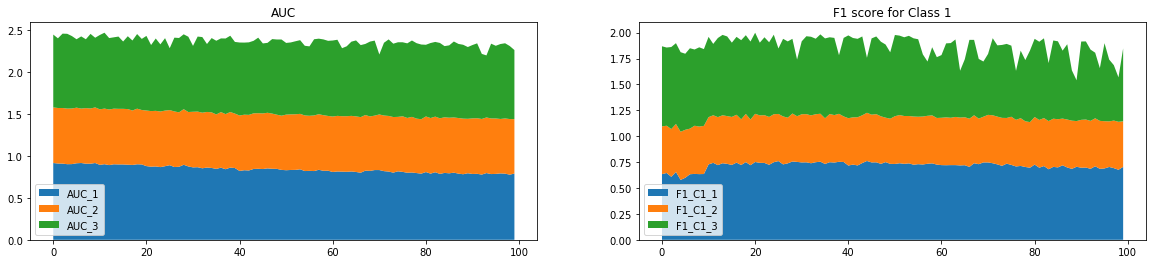

In [569]:
f, axarr = plt.subplots(1,2,figsize=(20,4))

y = results.loc[:,results.columns.str.startswith('AUC')].values.T
x=range(100)
l = results.columns[results.columns.str.startswith('AUC')].values
axarr[0].stackplot(x,y, labels=l)
axarr[0].legend(loc='lower left')
axarr[0].set_title('AUC')

y = results.loc[:,results.columns.str.startswith('F1')].values.T
x=range(100)
l = results.columns[results.columns.str.startswith('F1')].values
axarr[1].stackplot(x,y, labels=l)
axarr[1].legend(loc='lower left')
axarr[1].set_title('F1 score for Class 1')

plt.show()
fig.savefig('trainingRatioOptimization.png', dpi=fig.dpi)

In [602]:
# Get the ratio that maximizes AUC and F1_C1 on the 3 models
results['max_auc'] = results.apply(lambda row: row.AUC_1+row.AUC_2+row.AUC_3, axis=1)
results['max_f1_c1'] = results.apply(lambda row: row.F1_C1_1+row.F1_C1_2+row.F1_C1_3, axis=1)
results['ratio_1'] = results.Ratio.apply(lambda x: round(float(x.split(":")[0]),3))
results['ratio_2'] = results.Ratio.apply(lambda x: round(float(x.split(":")[1]),3))
# results.drop('Ratio', axis=1, inplace=True
max_auc = results.loc[:,["max_auc","max_f1_c1","ratio_1","ratio_2"]].sort_values(["max_auc","max_f1_c1"], ascending=False).reset_index()
max_f1 = results.loc[:,["max_auc","max_f1_c1","ratio_1","ratio_2"]].sort_values(["max_f1_c1","max_auc"], ascending=False).reset_index()


In [603]:
max_auc.head()

,index,max_auc,max_f1_c1,ratio_1,ratio_2
0,11,2.473,1.891,0.107,0.144
1,2,2.462,1.861,0.070,0.189
2,3,2.460,1.898,0.070,0.233
3,8,2.459,1.858,0.070,0.456
4,18,2.457,1.975,0.107,0.456


In [604]:
max_auc.drop(['index','max_auc','max_f1_c1'], axis=1, inplace=True)
max_auc_perc = max_auc.divide(max_auc.sum(axis=1), axis=0)
max_auc.reset_index(inplace=True)
max_f1.drop(['index','max_auc','max_f1_c1'], axis=1, inplace=True)
max_f1_perc = max_f1.divide(max_f1.sum(axis=1), axis=0)
max_f1.reset_index(inplace=True)

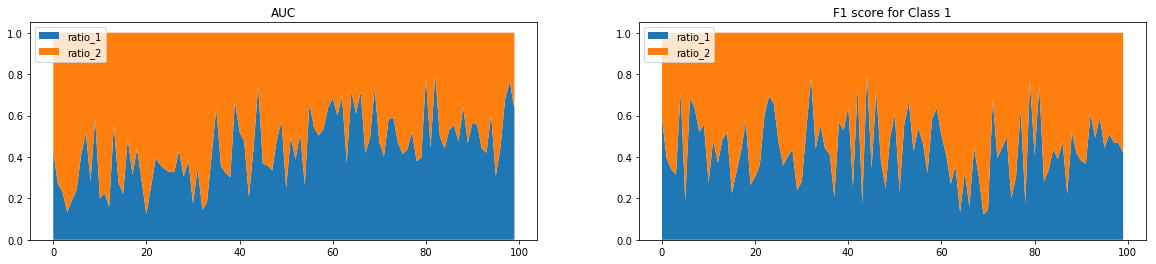

In [610]:
f, axarr = plt.subplots(1,2,figsize=(20,4))

# y = max_auc.loc[:,["ratio_1","ratio_2"]].values.T
x=range(100)
l = ["ratio_1","ratio_2"]
# axarr[0].stackplot(x,y, labels=l)
axarr[0].stackplot(x,  max_auc_perc["ratio_1"],  max_auc_perc["ratio_2"], labels=l)
axarr[0].legend(loc='upper left')
axarr[0].set_title('AUC')

# y = max_f1.loc[:,["ratio_1","ratio_2"]].values.T
x=range(100)
l = ["ratio_1","ratio_2"]
# axarr[1].stackplot(x,y, labels=l)
axarr[1].stackplot(x,  max_f1_perc["ratio_1"],  max_f1_perc["ratio_2"], labels=l)
axarr[1].legend(loc='upper left')
axarr[1].set_title('F1 score for Class 1')

plt.show()
fig.savefig('trainingRatioOptimization2.png', dpi=fig.dpi)

In [613]:
results.sort_values(["max_f1_c1","max_auc"], ascending=False).head()

,x,Ratio,AUC_1,AUC_2,AUC_3,F1_C1_1,F1_C1_2,F1_C1_3,max_auc,max_f1_c1,ratio_1,ratio_2
20,20,0.14333333333333334:0.1,0.880,0.664,0.891,0.751,0.465,0.783,2.435,1.999,0.143,0.100
34,34,0.18:0.2777777777777778,0.858,0.664,0.887,0.754,0.463,0.766,2.409,1.983,0.180,0.278
24,24,0.14333333333333334:0.2777777777777778,0.879,0.664,0.865,0.749,0.463,0.768,2.408,1.980,0.143,0.278
13,13,0.10666666666666667:0.23333333333333334,0.902,0.664,0.852,0.739,0.463,0.776,2.418,1.978,0.107,0.233
50,50,0.25333333333333335:0.1,0.831,0.664,0.856,0.732,0.461,0.784,2.351,1.977,0.253,0.100


---

In [20]:
# Optimal classifiers. 
clf1 = DecisionTreeClassifier(max_depth=2, max_leaf_nodes=42, min_samples_split=2, random_state=42)
clf2 = SGDClassifier(learning_rate='optimal', loss='log', max_iter=4, penalty='l1', random_state=42)
clf3 = LogisticRegression(class_weight='balanced', random_state=42)

clfs = [
    ("DecTree", clf1),
    ("SVMwithSGD", clf2),
    ("LogReg", clf3)
]


mixed_pipe = Pipeline([
    ("voting", VotingClassifier(clfs, voting="soft"))
])

In [ ]:
start = time()

mixed_pipe.fit(X_train, y_train)
y_val_pred = mixed_pipe.predict(X_val)

# These predictions can then be used to evaluate the classifier:

# y_train_scores = cross_val_score(mixed_pipe, X_train, y_train, cv=10)
y_train_pred = cross_val_predict(mixed_pipe, X_train, y_train, cv=10)

print(time()-start)

In [102]:
res = get_metrics(pd.DataFrame(), y_train, y_train_pred, 'Training')
res = get_metrics(res, y_val, y_val_pred, 'Validation')
res

,AUC,Acc,F1_C0,F1_C1,MSE,Prec_C0,Prec_C1,Recal_C0,Recal_C1
Training,0.784,0.964,0.981,0.684,0.036,0.97,0.844,0.992,0.575
Validation,0.779,0.963,0.981,0.673,0.037,0.97,0.826,0.991,0.567


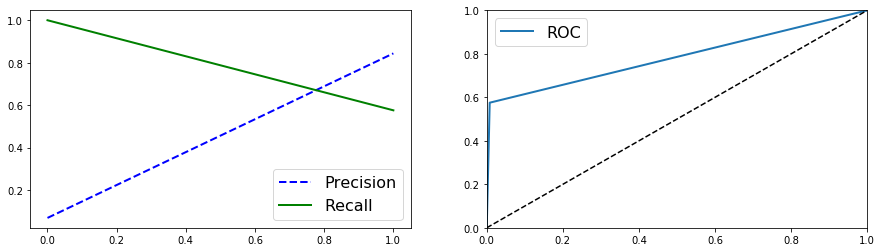

In [103]:
def plot_curves(y_train, y_train_pred):
    # create 2 subplots (horizontally stacked)

    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred)
    precision, recall, f = precision_recall_curve(y_train, y_train_pred)

    fig, axarr = plt.subplots(1,2,figsize=(15,4))

    axarr[0].plot(f, precision[:-1], "b--", label="Precision", linewidth=2)
    axarr[0].plot(f, recall[:-1], "g-", label="Recall", linewidth=2)
    axarr[0].legend(loc="top", fontsize=16)

    # axarr[0].xlabel("Threshold", fontsize=16)
    # axarr[0].ylim([0, 1])

    axarr[1].plot(fpr, tpr, linewidth=2, label='ROC')
    axarr[1].plot([0, 1], [0, 1], 'k--')
    axarr[1].axis([0, 1, 0, 1])
    axarr[1].legend(loc="upper left", fontsize=16)

    plt.show()

plot_curves(y_val, y_val_pred)

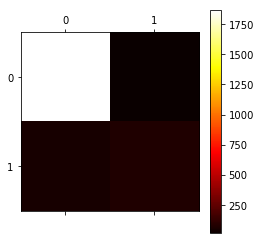

In [106]:
plt.matshow(metrics.confusion_matrix(y_val, y_val_pred), cmap=plt.cm.hot)
plt.colorbar()
plt.show()

# Answer: 
- Dealing with unbalanced dataset: 
    - Even up the training set: train the model with all of the minority class instances and an almost same amount of instances of the majority class. 

In [110]:
X_test, vc, vt = vectorizer(False, preprocessing(test), vc, vt)
y_test = test.PreventiveFlag.values

In [111]:
y_test_pred = mixed_pipe.predict(X_test)